In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [161]:
para = 'nback'
blacklist = [] # emoid: 180; rest: 220,233,274,284,472

subidsRest = [_id for _id in meta if para in meta[_id] and int(meta[_id][para]) not in blacklist] 

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', para, meta[subid][para]) for subid in subidsRest]

print('Loading complete')
print(len(rest_ts))

Loading complete
907


In [173]:
nTrain = 600

rest_ts = rest_ts[0:700]
perm = torch.randperm(len(rest_ts))
trainIdx = perm[:nTrain]
testIdx = perm[nTrain:]

In [174]:
# Convert to pytorch
# Split into train and test

import numpy as np
import torch

rest_p_t = torch.from_numpy(np.stack([np.corrcoef(ts) for ts in rest_ts])).float().cuda()

rest_p_t_train = rest_p_t[trainIdx].cuda()
rest_p_t_test = rest_p_t[testIdx].cuda()

print(rest_p_t.shape)
print(rest_p_t_train.shape)
print(rest_p_t_test.shape)

torch.Size([700, 264, 264])
torch.Size([600, 264, 264])
torch.Size([100, 264, 264])


In [176]:
# Ages

ages = []

for _id in meta:
    if para in meta[_id] and int(meta[_id][para]) not in blacklist:
        ages.append(meta[_id]['meta']['AgeInMonths']/12)

ages = torch.tensor(ages[0:700]).float()
ages_train = ages[trainIdx].cuda()
ages_test = ages[testIdx].cuda()

print(ages.shape)
print(ages_train.shape)
print(ages_test.shape)

torch.Size([700])
torch.Size([600])
torch.Size([100])


In [177]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv

nRoi = rest_p_t_train.shape[1]
nHid = 100

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('aij,bij->ab',ps1,ps2)
    F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
#         self.fc1 = nn.Linear(nRoi*nRoi,nHid).float().cuda()
#         self.fc2 = nn.Linear(nHid,1).float().cuda()
#         self.ei = torch.ones(2,nSub*nSub).long().cuda()
        self.gc1 = DenseGCNConv(nRoi*nRoi,nHid).float().cuda()
        self.gc2 = DenseGCNConv(nHid,1).float().cuda()
        self.gc3 = DenseGCNConv(nHid,1).float().cuda()
        
    def forward(self, x):
#         nB = x[0].shape[0]
        A = x[1]
        x = x[0]
#         A = calcEdges(x, x)
#         x = x.reshape(nB,nRoi*nRoi)
        x = F.relu(self.gc1(x,A))
        x = F.relu(self.gc2(x,A))
#         x = self.gc3(x,A)
#         x = torch.einsum('ab,bf->af',L,x)
#         x = F.relu(self.fc1(x))
#         x = torch.einsum('ab,bf->af',L,x)
#         x = self.fc2(x)
        return x
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2)

nEpoch = 30000
pPrint = 500

x = rest_p_t_train
A = calcEdges(x, x)
# xx = x.unsqueeze(0).reshape(1,-1,nRoi*nRoi)
# A = normalize((1/(torch.cdist(xx,xx)+torch.eye(nTrain).float().cuda())).squeeze(0))
z = x.reshape(-1,nRoi*nRoi)

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([z,A]).flatten()
    loss = torch.mean((pred - ages_train)**2)**0.5
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=14.869176864624023
epoch 500 loss=2.9074807167053223
epoch 1000 loss=2.380169630050659
epoch 1500 loss=2.0435686111450195
epoch 2000 loss=1.8114432096481323
epoch 2500 loss=1.6595606803894043
epoch 3000 loss=1.5623350143432617
epoch 3500 loss=1.48686945438385
epoch 4000 loss=1.4307262897491455
epoch 4500 loss=1.3755972385406494
epoch 5000 loss=1.332025408744812
epoch 5500 loss=1.2946717739105225
epoch 6000 loss=1.2585524320602417
epoch 6500 loss=1.224673867225647
epoch 7000 loss=1.1900217533111572
epoch 7500 loss=1.1718374490737915
epoch 8000 loss=1.1319224834442139
epoch 8500 loss=1.1065987348556519
epoch 9000 loss=1.076636791229248
epoch 9500 loss=1.0568878650665283
epoch 10000 loss=1.040059208869934
epoch 10500 loss=1.0037760734558105
epoch 11000 loss=0.9819222092628479
epoch 11500 loss=0.9594738483428955
epoch 12000 loss=0.9438812136650085
epoch 12500 loss=0.9307879209518433
epoch 13000 loss=0.904887318611145
epoch 13500 loss=0.8809555768966675
epoch 14000 loss=0.87039

In [178]:
# Test against baseline

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(nRoi*nRoi,1).float().cuda()
        
    def forward(self, x):
        x = self.fc1(x)
        return x
    
mlp = MLP()
optim = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=0.2)

nEpoch = 2000
pPrint = 400

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = mlp(rest_p_t_train.reshape(-1,nRoi*nRoi)).flatten()
    loss = torch.mean((pred - ages_train)**2)**0.5
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=15.302299499511719
epoch 400 loss=1.5357115268707275
epoch 800 loss=0.3613995909690857
epoch 1200 loss=0.14491486549377441
epoch 1600 loss=0.09484174102544785
epoch 1999 loss=0.07812041789293289
Complete


In [182]:
import itertools
import random
import copy

nConnEdge = rest_p_t.shape[1]
# nHid = 30

class DiffGraph(nn.Module):
    def __init__(self):
        super(DiffGraph, self).__init__()
        self.fc = nn.Linear(2*nRoi*nRoi,1).float().cuda()
        
    def forward(self, x):
        return self.fc(x)
    
dg = DiffGraph()
optim = torch.optim.Adam(dg.parameters(), lr=5e-5, weight_decay=0.2)

nEpoch = 5
bSize = 1000
pPeriod = 10000

pairs = list(itertools.combinations_with_replacement(np.arange(nTrain),2))

for i in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {i}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A = rest_p_t_train[Ai,:,:]
        B = rest_p_t_train[Bi,:,:]
        a = ages_train[list(Ai)]
        b = ages_train[list(Bi)]
        optim.zero_grad()
        pos = torch.cat([A,B],dim=1)
        neg = torch.cat([B,A],dim=1)
        posRes = dg(pos.reshape(-1,2*nRoi*nRoi)).flatten()
        negRes = dg(neg.reshape(-1,2*nRoi*nRoi)).flatten()
        posLoss = torch.mean((posRes-(a-b))**2)**0.5
        negLoss = torch.mean((negRes-(b-a))**2)**0.5
        (posLoss+negLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0:
            print(f'\tposLoss={posLoss} negLoss={negLoss} complete={nComplete}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=4.768857955932617 negLoss=4.7844109535217285 complete=0
	posLoss=4.526993274688721 negLoss=4.518558502197266 complete=10000
	posLoss=4.230702877044678 negLoss=4.233983993530273 complete=20000
	posLoss=4.0138959884643555 negLoss=4.017037391662598 complete=30000
	posLoss=3.785414457321167 negLoss=3.787764072418213 complete=40000
	posLoss=3.68928861618042 negLoss=3.6962008476257324 complete=50000
	posLoss=3.5221660137176514 negLoss=3.5241031646728516 complete=60000
	posLoss=3.4714248180389404 negLoss=3.4761228561401367 complete=70000
	posLoss=3.320161819458008 negLoss=3.3219847679138184 complete=80000
	posLoss=3.189619779586792 negLoss=3.1959261894226074 complete=90000
	posLoss=3.0050876140594482 negLoss=3.0037426948547363 complete=100000
	posLoss=2.9118287563323975 negLoss=2.914954900741577 complete=110000
	posLoss=3.007077217102051 negLoss=3.007737874984741 complete=120000
	posLoss=2.843893051147461 negLoss=2.8461594581604004 complete=130000
	posLoss=2.7306478023529053 

	posLoss=0.21557269990444183 negLoss=0.21634802222251892 complete=20000
	posLoss=0.24265804886817932 negLoss=0.23401261866092682 complete=30000
	posLoss=0.24833980202674866 negLoss=0.23988980054855347 complete=40000
	posLoss=0.24271050095558167 negLoss=0.2260259985923767 complete=50000
	posLoss=0.22218284010887146 negLoss=0.21410022675991058 complete=60000
	posLoss=0.22272419929504395 negLoss=0.23223571479320526 complete=70000
	posLoss=0.21888728439807892 negLoss=0.2091052234172821 complete=80000
	posLoss=0.22402456402778625 negLoss=0.2229466587305069 complete=90000
	posLoss=0.19973772764205933 negLoss=0.19047796726226807 complete=100000
	posLoss=0.20924219489097595 negLoss=0.20983611047267914 complete=110000
	posLoss=0.18416404724121094 negLoss=0.1775876134634018 complete=120000
	posLoss=0.21331903338432312 negLoss=0.21088792383670807 complete=130000
	posLoss=0.199138805270195 negLoss=0.2070837914943695 complete=140000
	posLoss=0.1943788081407547 negLoss=0.19540244340896606 complete=1

In [183]:
# Test

ap = np.zeros(len(testIdx))
an = np.zeros(len(testIdx))

for i in range(rest_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
    A = rest_p_t_test[i].expand(nTrain,-1,-1)
    a = ages_test[i].expand(nTrain)

    B = rest_p_t_train
    b = ages_train

    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    posRes = dg(pos.reshape(-1,2*nRoi*nRoi)).flatten()
    negRes = dg(neg.reshape(-1,2*nRoi*nRoi)).flatten()

    agePos = posRes + b
    ageNeg = b - negRes

    ap[i] = torch.mean(agePos).detach().cpu().numpy()
    an[i] = torch.mean(ageNeg).detach().cpu().numpy()
    
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
ap = ap[idcs]
an = an[idcs]
am = (ap+an)/2
y = y[idcs]

print('Positive')

corr = np.corrcoef(y, ap)
rmse = np.mean((y-ap)**2)**0.5
mae = np.mean(np.abs(y-ap))

print(corr)
print(rmse)
print(mae)

print('Negative')

corr = np.corrcoef(y, an)
rmse = np.mean((y-an)**2)**0.5
mae = np.mean(np.abs(y-an))

print(corr)
print(rmse)
print(mae)

print('Mean')

corr = np.corrcoef(y, am)
rmse = np.mean((y-am)**2)**0.5
mae = np.mean(np.abs(y-am))

print(corr)
print(rmse)
print(mae)

done 0
done 20
done 40
done 60
done 80
Positive
[[1.         0.73498072]
 [0.73498072 1.        ]]
2.27332516634032
1.800341796875
Negative
[[1.         0.73632115]
 [0.73632115 1.        ]]
2.238471150582919
1.7869845867156982
Mean
[[1.         0.73569982]
 [0.73569982 1.        ]]
2.253545543016929
1.792233395576477


[[1.        0.7225195]
 [0.7225195 1.       ]]
2.330773197944482
1.9344184
[[1.         0.75755541]
 [0.75755541 1.        ]]
2.187406701414389
1.7989691


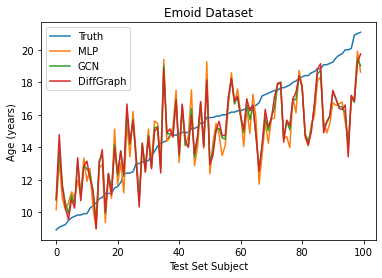

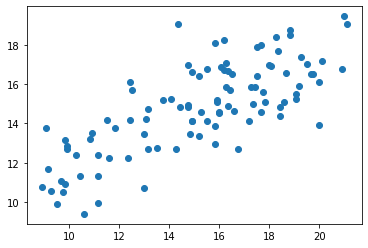

In [181]:
import matplotlib.pyplot as plt

x = rest_p_t
A = calcEdges(x, x)
# xx = x.unsqueeze(0).reshape(1,-1,nRoi*nRoi)
# A = normalize((1/(torch.cdist(xx,xx)+torch.eye(678).float().cuda())).squeeze(0))
z = x.reshape(-1,nRoi*nRoi)

pred1 = mlp(rest_p_t[testIdx].reshape(-1,nRoi*nRoi)).flatten().detach().cpu().numpy()
pred2 = gcn([z,A])
pred2 = pred2.flatten()[testIdx].detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
pred1 = pred1[idcs]
pred2 = pred2[idcs]
y = y[idcs]

corr = np.corrcoef(y, pred1)
rmse = np.mean((y-pred1)**2)**0.5
mae = np.mean(np.abs(y-pred1))

print(corr)
print(rmse)
print(mae)

corr = np.corrcoef(y, pred2)
rmse = np.mean((y-pred2)**2)**0.5
mae = np.mean(np.abs(y-pred2))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(pred1, label='MLP')
plt.plot(pred2, label='GCN')
plt.plot(am, label='DiffGraph')
plt.legend()
plt.xlabel('Test Set Subject')
plt.ylabel('Age (years)')
plt.title('Emoid Dataset')
plt.show()

plt.scatter(y, pred2)
plt.show()

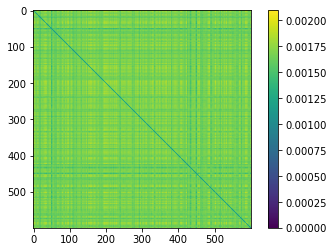

In [142]:
e = calcEdges(rest_p_t_train, rest_p_t_train)

plt.imshow(e.detach().cpu().numpy())
plt.colorbar()
plt.show()